In [3]:
import matplotlib.pyplot as plt
from ipynb.fs.defs.preprocessing import loadData
#from ipynb.fs.full.Model import applyPCA
import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es
import keras
import pandas as pd
from keras.layers import  Conv3D, Flatten, Dense, Reshape,MaxPool3D
from keras.layers import Dropout, Input, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import init_notebook_mode
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
from time import time
init_notebook_mode(connected=True)


In [4]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [5]:
dataset = 'IP'
test_ratio = 0.6
windowSize = 25

In [6]:

def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [7]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [8]:
X, y = loadData(dataset)


In [9]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

In [10]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [11]:
X,pca = applyPCA(X, numComponents=numComponents)

In [12]:
X = padWithZeros(X, PATCH_SIZE//2)

In [13]:
from tensorflow.keras.models import load_model

model = load_model("best-model.keras")

In [15]:
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

1/1 [==============================] - 0s 108ms/step


c:\Users\sachi\AppData\Local\Programs\Python\Python311\Lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



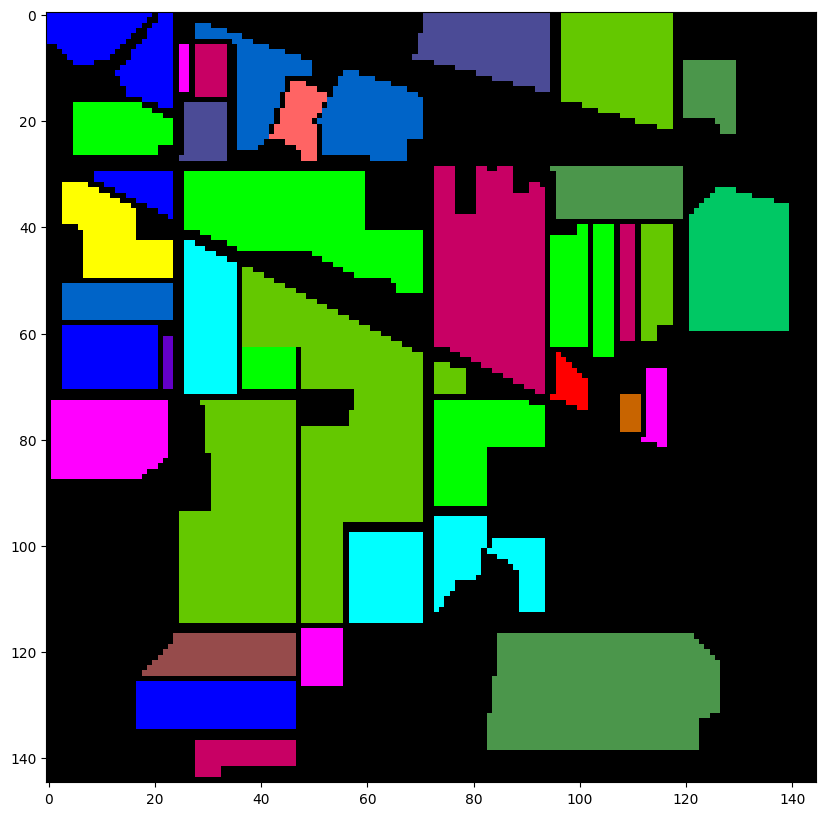

In [16]:

ground_truth = spectral.imshow(classes = y,figsize =(10,10))

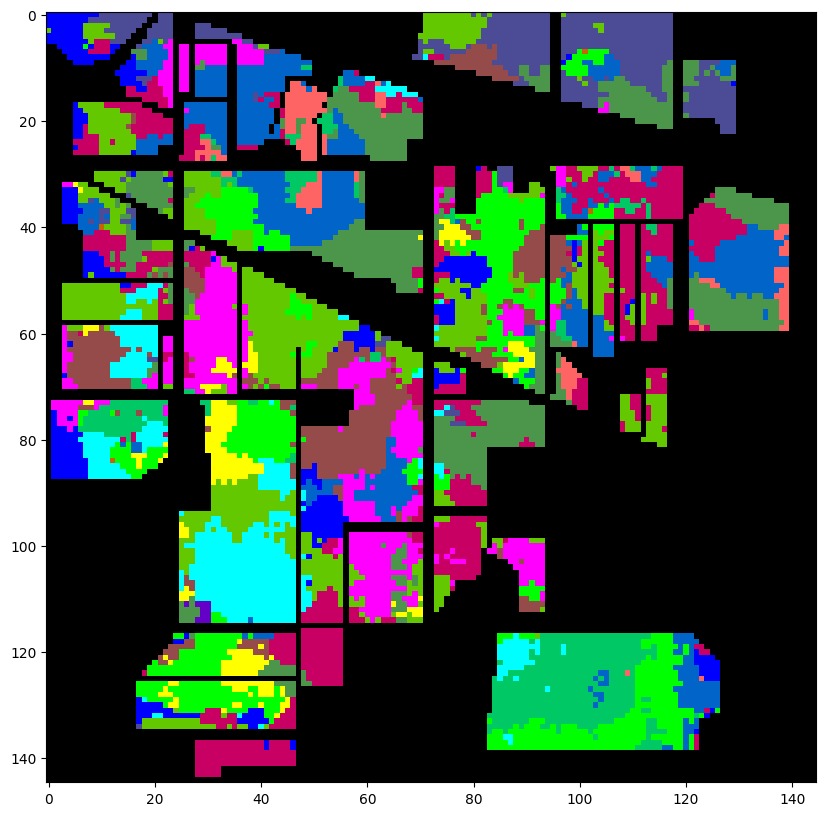

In [17]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(10,10))

In [18]:

spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

In [19]:
def Estimate_Area(spatial_resolution, label, n_class, class_mapping):
  Count = [0]* n_class
  Count = np.array(Count)
  for i in range(label.shape[0]):
    for j in range(label.shape[1]):
      idx = int(label[i][j])
      Count[idx] +=1
  
  area_of_one_pixel = float(spatial_resolution * spatial_resolution)
  for i in range(n_class):
    print("Area of "+class_mapping[i]+" == ","{0:.2f}".format((Count[i]*area_of_one_pixel)), "square metre")

In [20]:

class_mapping = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Background']

spatial_resolution_of_IP_dataset = 3.7
outputs = outputs -1



In [21]:
Estimate_Area(spatial_resolution_of_IP_dataset, outputs, 16, class_mapping)

Area of Alfalfa ==  0.00 square metre
Area of Corn-notill ==  15606.60 square metre
Area of Corn-mintill ==  6612.27 square metre
Area of Corn ==  3751.06 square metre
Area of Grass-pasture ==  10801.41 square metre
Area of Grass-trees ==  8693.15 square metre
Area of Grass-pasture-mowed ==  54.76 square metre
Area of Hay-windrowed ==  8569.94 square metre
Area of Oats ==  150.59 square metre
Area of Soybean-notill ==  17660.10 square metre
Area of Soybean-mintill ==  18194.01 square metre
Area of Soybean-clean ==  14566.16 square metre
Area of Wheat ==  9049.09 square metre
Area of Woods ==  15278.04 square metre
Area of Buildings-Grass-Trees-Drives ==  8569.94 square metre
Area of Background ==  150275.13 square metre


In [38]:
def Estimate_Area1(spatial_resolution, label, n_class, class_mapping):
  Count = [0]* n_class
  Count = np.array(Count)
  for i in range(label.shape[0]):
    for j in range(label.shape[1]):
      idx = int(label[i][j])
      Count[idx] +=1
  classname=[]
  area=[]
  area_of_one_pixel = float(spatial_resolution * spatial_resolution)
  for i in range(n_class):
    #print("Area of "+class_mapping[i]+" == ","{0:.2f}".format((Count[i]*area_of_one_pixel)), "square metre")
    classname.append(class_mapping[i])
    
    area.append("{0:.2f}".format((Count[i]*area_of_one_pixel)))
  return classname, area
  

In [45]:
class_mapping = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Background']

spatial_resolution_of_IP_dataset = 3.7
outputs = outputs -1

In [46]:
data=Estimate_Area1(spatial_resolution_of_IP_dataset, outputs, 16, class_mapping)
data


(['Alfalfa',
  'Corn-notill',
  'Corn-mintill',
  'Corn',
  'Grass-pasture',
  'Grass-trees',
  'Grass-pasture-mowed',
  'Hay-windrowed',
  'Oats',
  'Soybean-notill',
  'Soybean-mintill',
  'Soybean-clean',
  'Wheat',
  'Woods',
  'Buildings-Grass-Trees-Drives',
  'Background'],
 ['54.76',
  '8569.94',
  '150.59',
  '17660.10',
  '18194.01',
  '14566.16',
  '9049.09',
  '15278.04',
  '8569.94',
  '150275.13',
  '0.00',
  '15606.60',
  '6612.27',
  '3751.06',
  '10801.41',
  '8693.15'])

In [47]:
data

(['Alfalfa',
  'Corn-notill',
  'Corn-mintill',
  'Corn',
  'Grass-pasture',
  'Grass-trees',
  'Grass-pasture-mowed',
  'Hay-windrowed',
  'Oats',
  'Soybean-notill',
  'Soybean-mintill',
  'Soybean-clean',
  'Wheat',
  'Woods',
  'Buildings-Grass-Trees-Drives',
  'Background'],
 ['54.76',
  '8569.94',
  '150.59',
  '17660.10',
  '18194.01',
  '14566.16',
  '9049.09',
  '15278.04',
  '8569.94',
  '150275.13',
  '0.00',
  '15606.60',
  '6612.27',
  '3751.06',
  '10801.41',
  '8693.15'])

In [49]:
import csv

# Create a tuple containing two lists
tuple_of_lists = data

# Open a CSV file in write mode
with open('tuple_to_csv.csv', 'w', newline='') as csvfile:

    # Create a CSV writer object
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(tuple_of_lists[0])

    # Write the data rows
    for row in tuple_of_lists[1:]:
        writer.writerow(row)

# Close the CSV file
csvfile.close()

In [54]:
import pickle as pkl
import pandas as pd

df=pd.read_csv('result1.csv')
df.to_pickle('result.pkl')